In [2]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

UsageError: Line magic function `%` not found.


# Data Exploration & Data Cleaning

The first step will be to explore the 3 provided datasets in json format. The main point is to understand the general structure of the data, to explore the distribution of the data to see if any relationship can be found. It's more a general overview of the project. During the data cleaning part, files that contain any missing rows will be dropped from the datasets. Also columns that have ambiguous data such as in the profile.json, age column with values of 118 will be removed. Because there is no way someone is 118 years old. Also during this part data will be merged into a meaningful structure, such as combination of transactions with the profile data.

In [20]:
# read in the json files
portfolio = pd.read_json('../input/portfolio.json', orient='records', lines=True)
profile = pd.read_json('../input/profile.json', orient='records', lines=True)
transcript = pd.read_json('../input/transcript.json', orient='records', lines=True)

In [6]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [21]:
portfolio = portfolio.rename(columns={'id': 'offer_id', 
                                      'difficulty': 'required_spend',
                                     })

In [22]:
dummies = pd.get_dummies(portfolio['channels'].apply(pd.Series).stack(), prefix='channel').sum(level=0)
portfolio = portfolio.merge(dummies, left_index=True, right_index=True)
portfolio = portfolio.drop('channels', axis=1)

In [23]:
portfolio['offer_name'] = portfolio['offer_type'] + '-' + portfolio['required_spend'].astype(str) + 'spend-' + + portfolio['reward'].astype(str) + 'reward-' + portfolio['duration'].astype(str) + 'days' 

In [10]:
portfolio

reward  required_spend  duration     offer_type  \
0      10              10         7           bogo   
1      10              10         5           bogo   
2       0               0         4  informational   
3       5               5         7           bogo   
4       5              20        10       discount   
5       3               7         7       discount   
6       2              10        10       discount   
7       0               0         3  informational   
8       5               5         5           bogo   
9       2              10         7       discount   

                           offer_id  channel_email  channel_mobile  \
0  ae264e3637204a6fb9bb56bc8210ddfd              1               1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0              1               1   
2  3f207df678b143eea3cee63160fa8bed              1               1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9              1               1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7              1               0   
5  2298d6c36e964ae4a3e7e9706d1fb8c2              1               1   
6  fafdcd668e3743c1bb461111dcafc2a4              1               1   
7  5a8bc65990b245e5a138643cd4eb9837              1               1   
8  f19421c1d4aa40978ebb69ca19b0e20d              1               1   
9  2906b810c7d4411798c6938adc9daaa5              1               1   

   channel_social  channel_web                          offer_name  
0               1            0         bogo-10spend-10reward-7days  
1               1            1         bogo-10spend-10reward-5days  
2               0            1  informational-0spend-0reward-4days  
3               0            1           bogo-5spend-5reward-7days  
4               0            1     discount-20spend-5reward-10days  
5               1            1       discount-7spend-3reward-7days  
6               1            1     discount-10spend-2reward-10days  
7               1            0  informational-0spend-0reward-3days  
8               1            1           bogo-5spend-5reward-5days  
9               0            1      discount-10spend-2reward-7days

In [11]:
portfolio.duplicated().sum()

0

In [24]:
profile.head(5)

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [34]:
profile.shape

(17000, 8)

In [25]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['became_member_year'] = pd.DatetimeIndex(profile['became_member_on']).year
profile['became_member_month'] = pd.DatetimeIndex(profile['became_member_on']).month

In [26]:
profile['membership_duration'] = (profile['became_member_on'].max() - profile['became_member_on'])

In [27]:
profile.head(5)

gender  age                                id became_member_on    income  \
0   None  118  68be06ca386d4c31939f3a4f0e3dd783       2017-02-12       NaN   
1      F   55  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
2   None  118  38fe809add3b4fcf9315a9694bb96ff5       2018-07-12       NaN   
3      F   75  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0   
4   None  118  a03223e636434f42ac4c3df47e8bac43       2017-08-04       NaN   

   became_member_year  became_member_month membership_duration  
0                2017                    2            529 days  
1                2017                    7            376 days  
2                2018                    7             14 days  
3                2017                    5            443 days  
4                2017                    8            356 days

In [32]:
def dig_view():
    fig, axes = plt.subplots(2, 2, figsize=(15,7))

    profile['age'].plot(kind='hist', ax=axes[0, 0], title='Age').set_xlabel('years')
    profile['gender'].value_counts().plot(kind='bar', ax=axes[0, 1], title='Gender').set_xlabel('category')
    profile['income'].plot(kind='hist', ax=axes[1, 0], title='Income').set_xlabel('amount')
    profile['became_member_year'].value_counts().sort_index().plot(kind='bar', ax=axes[1, 1], title='Became member on').set_xlabel('year')

    plt.subplots_adjust(hspace = 0.3, bottom=0.1)
    plt.show()
    
dig_view()

In [29]:
profile['age'] = profile['age'].replace(118, np.nan)

In [30]:
# Dropping O to maintain the balance in the dataset for further prediction
profile['gender'] = profile[profile['gender'] !='O']

In [33]:
dig_view()

In [47]:
profile['gender'].value_counts()

M    8484
F    6129
Name: gender, dtype: int64

In [48]:
profile['gender'] = profile['gender'].map({'M': 0, 'F': 1})

In [49]:
profile['gender'].value_counts()

0.0    8484
1.0    6129
Name: gender, dtype: int64

In [50]:
profile.duplicated().sum()

0

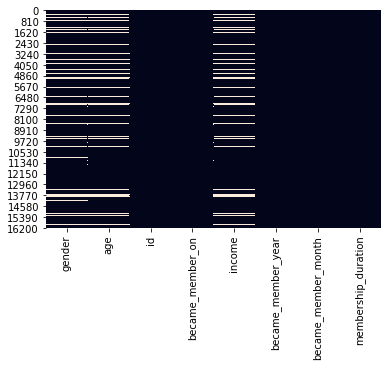

In [51]:
sns.heatmap(profile.isnull(), cbar=False)

In [52]:
profile = profile.drop(profile[profile['gender'].isnull()].index)

In [53]:
sns.heatmap(profile.isnull(), cbar=False)

In [54]:
profile.shape

(14613, 8)

In [35]:
17000 - 14613

2387

In [55]:
# grouping ages into groups to combine them into categories
# binning of age -> transform into descrete groups
bins = [10, 20, 30, 40, 50, 60, 70, 80, 120]
group_names = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+']
profile['age_categories'] = pd.cut(profile['age'], bins, labels=group_names)

In [56]:
bins = [20000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000]
labels = ['20k-39k', '40k-49k', '50k-59k', '60k-69k', '70k-79k', '80k-89k', '90k-99k', '100k-109k', '110k-120k']
profile['income_binned'] = pd.cut(profile['income'], bins=bins, labels=labels)

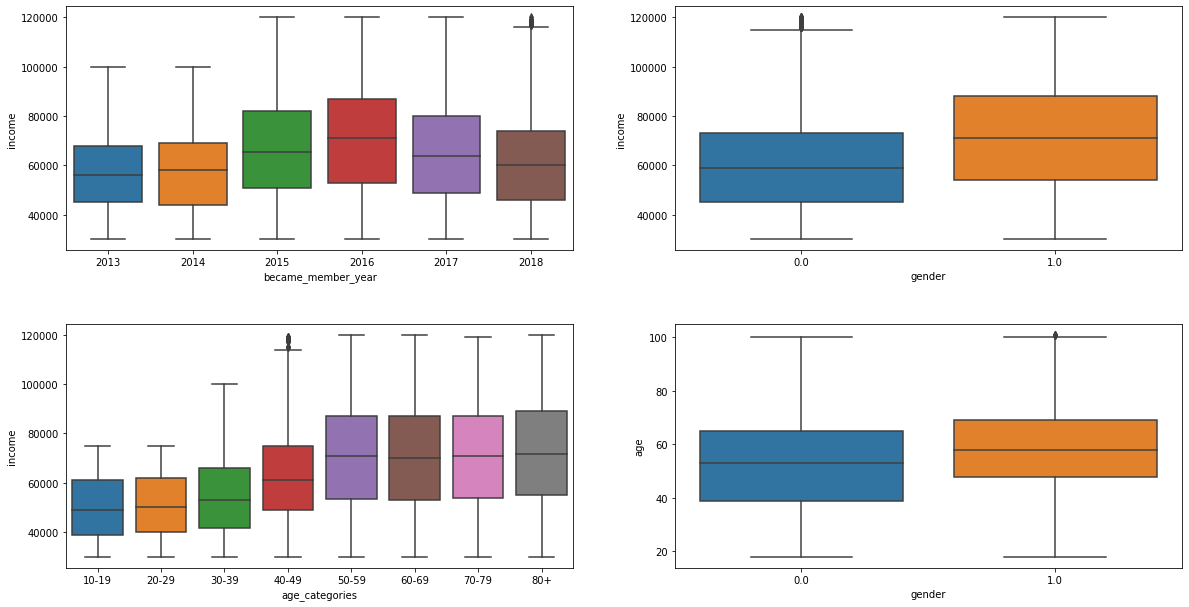

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.boxplot(data=profile, x='became_member_year', y='income', ax=axes[0, 0])
sns.boxplot(data=profile, x='gender', y='income', ax=axes[0, 1])
sns.boxplot(data=profile, x='age_categories', y='income', ax=axes[1, 0])
sns.boxplot(data=profile, x='gender', y='age', ax=axes[1, 1])
plt.subplots_adjust(hspace = 0.3, bottom=0.1)

In [58]:
profile = profile.rename(columns={'id': 'customer_id'})

In [29]:
transcript.head(5)

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

In [30]:
# getting the values out of a dict object
# combining both offer id and offer_id into a single column
values_df = pd.DataFrame(transcript['value'].tolist())
values_df['offerid'] = values_df['offer id'].combine_first(values_df['offer_id'])
values_df.drop(['offer id', 'offer_id'], axis=1, inplace=True)
index_df = pd.DataFrame({'idx': transcript.index.values.tolist()})
combined = index_df.merge(values_df, left_index=True, right_index=True)
combined_index = combined.set_index('idx')
transcript = transcript.merge(combined_index, left_index=True, right_index=True)

In [30]:
transcript.head(5)

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  amount  reward  \
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0     NaN     NaN   
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0     NaN     NaN   
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0     NaN     NaN   
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0     NaN     NaN   
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0     NaN     NaN   

                            offerid  
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  
1  0b1e1539f2cc45b7b9fa7c272da2e1d7  
2  2906b810c7d4411798c6938adc9daaa5  
3  fafdcd668e3743c1bb461111dcafc2a4  
4  4d5c57ea9a6940dd891ad53e9dbe8da0

In [31]:
transcript = transcript.merge(portfolio, left_on='offerid', right_on='offer_id', how='left')

In [32]:
transcript = transcript.rename(columns={'reward_x': 'paid_reward', 
                                        'reward_y': 'planned_reward', 
                                       })

In [33]:
transcript = transcript.rename(columns={'person': 'customer_id'})

In [34]:
transcript['time'] = transcript['time'] / 24

In [35]:
transcript = transcript.drop(columns=['value'])

In [36]:
print(transcript.duplicated().sum())

397


In [37]:
transcript = transcript.drop_duplicates().reset_index(drop=True)

In [38]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33182
Name: event, dtype: int64

In [39]:
transaction_df = transcript[transcript['event'] == 'transaction'].copy()
transaction_df = transaction_df[['customer_id', 'time', 'amount']]
transaction_df.head(5)

customer_id  time  amount
12654  02c083884c7d45b39cc68e1314fec56c   0.0    0.83
12657  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f   0.0   34.56
12659  54890f68699049c2a04d415abc25e717   0.0   13.23
12670  b2f1cd155b864803ad8334cdf13c4bd2   0.0   19.51
12671  fe97aa22dd3e48c8b143116a8403dd52   0.0   18.97

In [40]:
offer_df = transcript[transcript['event'] != 'transaction'].copy()
offer_df = pd.get_dummies(offer_df, columns=['event'], prefix=None)
offer_df = offer_df.drop(columns=['amount', 'offerid', 'paid_reward'], axis=1)

In [41]:
offer_df = offer_df.rename(columns={'event_offer completed': 'event_offer_completed',
                                   'event_offer received': 'event_offer_received',
                                    'event_offer viewed': 'event_offer_viewed'
                                   })

In [42]:
offer_df.head(5)

customer_id  time  planned_reward  required_spend  \
0  78afa995795e4d85b5d9ceeca43f5fef   0.0             5.0             5.0   
1  a03223e636434f42ac4c3df47e8bac43   0.0             5.0            20.0   
2  e2127556f4f64592b11af22de27a7932   0.0             2.0            10.0   
3  8ec6ce2a7e7949b1bf142def7d0e0586   0.0             2.0            10.0   
4  68617ca6246f4fbc85e91a2a49552598   0.0            10.0            10.0   

   duration offer_type                          offer_id  channel_email  \
0       7.0       bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9            1.0   
1      10.0   discount  0b1e1539f2cc45b7b9fa7c272da2e1d7            1.0   
2       7.0   discount  2906b810c7d4411798c6938adc9daaa5            1.0   
3      10.0   discount  fafdcd668e3743c1bb461111dcafc2a4            1.0   
4       5.0       bogo  4d5c57ea9a6940dd891ad53e9dbe8da0            1.0   

   channel_mobile  channel_social  channel_web  \
0             1.0             0.0          1.0   
1             0.0             0.0          1.0   
2             1.0             0.0          1.0   
3             1.0             1.0          1.0   
4             1.0             1.0          1.0   

                        offer_name  event_offer_completed  \
0        bogo-5spend-5reward-7days                      0   
1  discount-20spend-5reward-10days                      0   
2   discount-10spend-2reward-7days                      0   
3  discount-10spend-2reward-10days                      0   
4      bogo-10spend-10reward-5days                      0   

   event_offer_received  event_offer_viewed  
0                     1                   0  
1                     1                   0  
2                     1                   0  
3                     1                   0  
4                     1                   0

In [43]:
count_events = transcript['event'].value_counts()
total_events = count_events.sum()
percentage_transactions = count_events[0] / total_events * 100
percentage_offers = count_events[1:].sum() / total_events * 100

percentage_transactions, percentage_offers, count_events

(45.38915583545929, 54.610844164540715, transaction        138953
 offer received      76277
 offer viewed        57725
 offer completed     33182
 Name: event, dtype: int64)

In [44]:
print(portfolio.columns.to_list())
portfolio.head(1)

['reward', 'required_spend', 'duration', 'offer_type', 'offer_id', 'channel_email', 'channel_mobile', 'channel_social', 'channel_web', 'offer_name']


reward  required_spend  duration offer_type  \
0      10              10         7       bogo   

                           offer_id  channel_email  channel_mobile  \
0  ae264e3637204a6fb9bb56bc8210ddfd              1               1   

   channel_social  channel_web                   offer_name  
0               1            0  bogo-10spend-10reward-7days

In [45]:
print(transaction_df.columns.to_list())
transaction_df.head(1)

['customer_id', 'time', 'amount']


customer_id  time  amount
12654  02c083884c7d45b39cc68e1314fec56c   0.0    0.83

In [46]:
print(offer_df.columns.to_list())
offer_df.head(1)

['customer_id', 'time', 'planned_reward', 'required_spend', 'duration', 'offer_type', 'offer_id', 'channel_email', 'channel_mobile', 'channel_social', 'channel_web', 'offer_name', 'event_offer_completed', 'event_offer_received', 'event_offer_viewed']


customer_id  time  planned_reward  required_spend  \
0  78afa995795e4d85b5d9ceeca43f5fef   0.0             5.0             5.0   

   duration offer_type                          offer_id  channel_email  \
0       7.0       bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9            1.0   

   channel_mobile  channel_social  channel_web                 offer_name  \
0             1.0             0.0          1.0  bogo-5spend-5reward-7days   

   event_offer_completed  event_offer_received  event_offer_viewed  
0                      0                     1                   0

In [96]:
print(profile.columns.to_list())
profile.head(1)

['gender', 'age', 'customer_id', 'became_member_on', 'income', 'became_member_year', 'became_member_month', 'membership_duration', 'age_categories', 'income_binned']


gender   age                       customer_id became_member_on    income  \
1     1.0  55.0  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   

   became_member_year  became_member_month membership_duration age_categories  \
1                2017                    7            376 days          50-59   

  income_binned  
1     110k-120k

In [111]:
#get the list of customerIds from offer df
customer_ids = offer_df['customer_id'].unique()
print(customer_ids)

['78afa995795e4d85b5d9ceeca43f5fef' 'a03223e636434f42ac4c3df47e8bac43'
 'e2127556f4f64592b11af22de27a7932' ... 'd825b707198046e39baa4fdcfa11d621'
 'c207a8a8ef5c47ee970ca45f859e07eb' '9a3f45cf29ef428b932492c7a5d6ac52']


In [112]:
# adding offer end date to see if the offer completed is in range
offer_df['offer_ends'] = offer_df['time'] + offer_df['duration']

In [113]:
def filter_by_cid(df, cid):
    return df[df['customer_id'] == cid]

In [114]:
def get_received(df):
    return df[df['event_offer_received'] == 1]

def get_viewed(df):
    return df[df['event_offer_viewed'] == 1]

def get_completed(df):
    return df[df['event_offer_completed'] == 1]

In [367]:
# a03223e636434f42ac4c3df47e8bac43
# '78afa995795e4d85b5d9ceeca43f5fef'
cid_78_offers = filter_by_cid(offer_df, '78afa995795e4d85b5d9ceeca43f5fef')
cid_78_transactions = filter_by_cid(transaction_df, '78afa995795e4d85b5d9ceeca43f5fef')

In [368]:
received_offers = get_received(cid_78_offers)
viewed_offers = get_viewed(cid_78_offers)
completed_offers = get_completed(cid_78_offers)
completed_offers

customer_id   time  planned_reward  \
47583   78afa995795e4d85b5d9ceeca43f5fef   5.50             5.0   
218231  78afa995795e4d85b5d9ceeca43f5fef  21.25            10.0   
218232  78afa995795e4d85b5d9ceeca43f5fef  21.25             5.0   

        required_spend  duration offer_type                          offer_id  \
47583              5.0       7.0       bogo  9b98b8c7a33c4b65b9aebfe6a799e6d9   
218231            10.0       7.0       bogo  ae264e3637204a6fb9bb56bc8210ddfd   
218232             5.0       5.0       bogo  f19421c1d4aa40978ebb69ca19b0e20d   

        channel_email  channel_mobile  channel_social  channel_web  \
47583             1.0             1.0             0.0          1.0   
218231            1.0             1.0             1.0          0.0   
218232            1.0             1.0             1.0          1.0   

                         offer_name  event_offer_completed  \
47583     bogo-5spend-5reward-7days                      1   
218231  bogo-10spend-10reward-7days                      1   
218232    bogo-5spend-5reward-5days                      1   

        event_offer_received  event_offer_viewed  offer_ends  
47583                      0                   0       12.50  
218231                     0                   0       28.25  
218232                     0                   0       26.25

In [377]:
def completed_lookup(row, completed_offers):
    row_len = row.shape[0]
    if row_len > 0:
        offers = completed_offers.loc[completed_offers['offer_id'] == row['offer_id'], :]
        time = offers.loc[offers['time'] >= row['time'], 'time']
        val = time.values
        if len(val) == 0:
            return -1
        else:
            return val[0]

In [376]:
def viewed_lookup(idx, row, viewed_offers):
    row_len = row.shape[0]
    if row_len > 0:
        offers = viewed_offers.loc[viewed_offers['offer_id'] == row['offer_id'], :]
        time = offers.loc[offers['time'] >= row['time'], 'time']
        val = time.values
        if len(val) == 0:
            return -1
        else:
            return val[0]

In [375]:
def transaction_lookup(row, transactions_df):
    start = row['time']
    end = row['offer_ends']
    cid = row['customer_id']
    condition = (transactions_df['customer_id'] == cid)
    time = transactions_df.loc[condition, 'time'].between(start, end)
    amount = transactions_df.loc[time, 'amount'].sum()
    return amount

In [378]:
def calc_offers(cid):
    offers = filter_by_cid(offer_df, cid)
    transactions = filter_by_cid(transaction_df, cid)
    received_offers = get_received(offers)
    viewed_offers = get_viewed(offers)
    completed_offers = get_completed(offers)
    transactions = filter_by_cid(transaction_df, cid)
    received_offers.loc[:, 'completed_at'] = received_offers.apply(lambda row: completed_lookup(row, completed_offers), axis=1)
    received_offers.loc[:, 'viewed_at'] = received_offers.apply(lambda row: viewed_lookup(row.name, row, viewed_offers), axis=1)
    received_offers.loc[:, 'offer_success'] = (received_offers['offer_ends'] > received_offers['completed_at']) & (received_offers['viewed_at'] <= received_offers['completed_at']) & (received_offers['completed_at'] != -1) & (received_offers['viewed_at'] != -1)
    received_offers.loc[:, 'offer_success_no_view'] = (received_offers['completed_at'] > 0) & ((received_offers['viewed_at'] == -1) | (received_offers['viewed_at'] > received_offers['completed_at']))
    received_offers.loc[:, 'amount'] = received_offers.apply(lambda row: transaction_lookup(row, transactions), axis=1)
    received_offers.loc[:, 'offer_success'] = received_offers['offer_success'].map({True: 1, False: 0})
    received_offers.loc[:, 'offer_success_no_view'] = received_offers['offer_success_no_view'].map({True: 1, False: 0})
    return received_offers

In [379]:
vfunc = np.vectorize(calc_offers)
calculated_offer_df = pd.concat(vfunc(customer_ids))

In [384]:
calculated_offer_df.head(5)

customer_id  time  planned_reward  \
0       78afa995795e4d85b5d9ceeca43f5fef   0.0             5.0   
53176   78afa995795e4d85b5d9ceeca43f5fef   7.0             0.0   
150575  78afa995795e4d85b5d9ceeca43f5fef  17.0            10.0   
201427  78afa995795e4d85b5d9ceeca43f5fef  21.0             5.0   
1       a03223e636434f42ac4c3df47e8bac43   0.0             5.0   

        required_spend  duration     offer_type  \
0                  5.0       7.0           bogo   
53176              0.0       3.0  informational   
150575            10.0       7.0           bogo   
201427             5.0       5.0           bogo   
1                 20.0      10.0       discount   

                                offer_id  channel_email  channel_mobile  \
0       9b98b8c7a33c4b65b9aebfe6a799e6d9            1.0             1.0   
53176   5a8bc65990b245e5a138643cd4eb9837            1.0             1.0   
150575  ae264e3637204a6fb9bb56bc8210ddfd            1.0             1.0   
201427  f19421c1d4aa40978ebb69ca19b0e20d            1.0             1.0   
1       0b1e1539f2cc45b7b9fa7c272da2e1d7            1.0             0.0   

        channel_social  ...                          offer_name  \
0                  0.0  ...           bogo-5spend-5reward-7days   
53176              1.0  ...  informational-0spend-0reward-3days   
150575             1.0  ...         bogo-10spend-10reward-7days   
201427             1.0  ...           bogo-5spend-5reward-5days   
1                  0.0  ...     discount-20spend-5reward-10days   

       event_offer_completed  event_offer_received  event_offer_viewed  \
0                          0                     1                   0   
53176                      0                     1                   0   
150575                     0                     1                   0   
201427                     0                     1                   0   
1                          0                     1                   0   

        offer_ends  completed_at  viewed_at  offer_success  \
0              7.0          5.50       0.25              1   
53176         10.0         -1.00       9.00              0   
150575        24.0         21.25      17.00              1   
201427        26.0         21.25      24.25              0   
1             10.0         -1.00       0.25              0   

        offer_success_no_view  amount  
0                           0   37.67  
53176                       0   49.39  
150575                      0   48.28  
201427                      1   48.28  
1                           0    1.09  

[5 rows x 21 columns]

In [392]:
calculated_offer_df.shape

(76277, 21)

In [394]:
offer_df[offer_df['event_offer_received'] == 1].shape

(76277, 16)

In [59]:
profile.head(5)

gender   age                       customer_id became_member_on    income  \
1      1.0  55.0  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
3      1.0  75.0  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0   
5      0.0  68.0  e2127556f4f64592b11af22de27a7932       2018-04-26   70000.0   
8      0.0  65.0  389bc3fa690240e798340f5a15918d5c       2018-02-09   53000.0   
12     0.0  58.0  2eeac8d8feae4a8cad5a6af0499a211d       2017-11-11   51000.0   

    became_member_year  became_member_month membership_duration  \
1                 2017                    7            376 days   
3                 2017                    5            443 days   
5                 2018                    4             91 days   
8                 2018                    2            167 days   
12                2017                   11            257 days   

   age_categories income_binned  
1           50-59     110k-120k  
3           70-79       90k-99k  
5           60-69       60k-69k  
8           60-69       50k-59k  
12          50-59       50k-59k

In [8]:
#calculated_offer_df.to_csv('../input/offers.csv', index=False)
#profile.to_csv('../input/profile.csv', index=False)
#portfolio.to_csv('../input/portfolio.csv', index=False)

# Exploratory Analysis

Now the data is combined into a single dataframe that can be analysed to find patterns. During this part metrics such as conversion rate by offers, avg. spent by offers will be calculated and visualize to get a better understanding of the offer preformance by other dimensions.

In [84]:
offers = pd.read_csv('../input/offers.csv')
profile = pd.read_csv('../input/profile.csv')
portfolio = pd.read_csv('../input/portfolio.csv')

In [28]:
offers.shape

(76277, 21)

In [85]:
# removing amount from informational offers, so algorithm will be better predicting the success of an offer
offers.loc[(offers['offer_success'] == 0) & (offers['offer_success_no_view'] == 0), 'amount'] = 0

In [29]:
offers.columns

Index(['customer_id', 'time', 'planned_reward', 'required_spend', 'duration',
       'offer_type', 'offer_id', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web', 'offer_name', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'offer_ends',
       'completed_at', 'viewed_at', 'offer_success', 'offer_success_no_view',
       'amount'],
      dtype='object')

In [30]:
profile.head(5)

gender   age                       customer_id became_member_on    income  \
0     1.0  55.0  0610b486422d4921ae7d2bf64640c50b       2017-07-15  112000.0   
1     1.0  75.0  78afa995795e4d85b5d9ceeca43f5fef       2017-05-09  100000.0   
2     0.0  68.0  e2127556f4f64592b11af22de27a7932       2018-04-26   70000.0   
3     0.0  65.0  389bc3fa690240e798340f5a15918d5c       2018-02-09   53000.0   
4     0.0  58.0  2eeac8d8feae4a8cad5a6af0499a211d       2017-11-11   51000.0   

   became_member_year  became_member_month          membership_duration  \
0                2017                    7  376 days 00:00:00.000000000   
1                2017                    5  443 days 00:00:00.000000000   
2                2018                    4   91 days 00:00:00.000000000   
3                2018                    2  167 days 00:00:00.000000000   
4                2017                   11  257 days 00:00:00.000000000   

  age_categories income_binned  
0          50-59     110k-120k  
1          70-79       90k-99k  
2          60-69       60k-69k  
3          60-69       50k-59k  
4          50-59       50k-59k

In [86]:
offers = offers.merge(profile, left_on='customer_id', right_on='customer_id', how='inner')

In [32]:
offers.shape

(65585, 30)

In [33]:
offers.columns

Index(['customer_id', 'time', 'planned_reward', 'required_spend', 'duration',
       'offer_type', 'offer_id', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web', 'offer_name', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'offer_ends',
       'completed_at', 'viewed_at', 'offer_success', 'offer_success_no_view',
       'amount', 'gender', 'age', 'became_member_on', 'income',
       'became_member_year', 'became_member_month', 'membership_duration',
       'age_categories', 'income_binned'],
      dtype='object')

In [19]:
best_offers_cr = pd.DataFrame(offers.groupby(['offer_name', 'offer_success']).count()['offer_type'])
best_offers_cr = best_offers_cr.groupby(level=0).transform(lambda x: x[1] / x.sum() if len(x) == 2 else 0).unstack(level=0)
best_offers_cr = best_offers_cr.iloc[0, :]
best_offers_cr = pd.DataFrame(best_offers_cr).reset_index().rename({0: 'percentage'}, axis=1)

In [20]:
plt.figure(figsize=(10, 5))
offer_chart = sns.barplot(data=best_offers_cr.iloc[:-2, :], x='offer_name', y='percentage')
offer_chart.set_xticklabels(
    offer_chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
offer_chart.set_title('Conversion rate by offers')
plt.show()

In [21]:
best_offers_mean = offers.groupby(['offer_name'])['amount'].mean()
best_offers_mean = pd.DataFrame(best_offers_mean).unstack(level=0).reset_index().rename({0: 'avg_spend'}, axis=1)
best_offers_mean = pd.DataFrame(best_offers_mean)

In [22]:
plt.figure(figsize=(10, 5))
offer_chart = sns.barplot(data=best_offers_mean.iloc[:-2, :], x='offer_name', y='avg_spend')
offer_chart.set_xticklabels(
    offer_chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')
offer_chart.set_title('Avg. spend by offers')
plt.show()

Text(0, 0.5, 'amount in $')

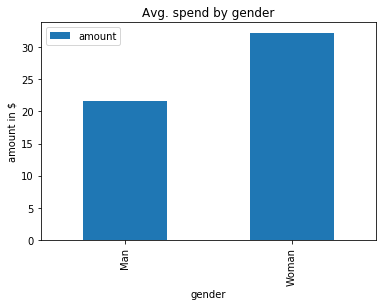

In [23]:
spend_gender = pd.DataFrame(offers.groupby(['gender'])['amount'].mean()).rename({0: 'Man', 1: 'Woman'})
spend_gender.plot(kind='bar', title='Avg. spend by gender').set_ylabel('amount in $')

In [24]:
conversion_by_gender = pd.DataFrame(offers.groupby(['gender', 'offer_success']).count())
conversion_by_gender = conversion_by_gender.unstack(level=0).loc[:, 'customer_id'].rename({0: 'Man', 1: 'Woman'}, axis=1)
conversion_by_gender = conversion_by_gender.apply(lambda x: x[1] / x.sum(), axis=0)
conversion_by_gender.plot(kind='bar', title='Conversion rate by gender').set_ylabel('percentage')

Text(0, 0.5, 'percentage')

In [25]:
conversion_by_age = pd.DataFrame(offers.groupby(['age_categories', 'offer_success']).count())
conversion_by_age = conversion_by_age.unstack(level=0).loc[:, 'customer_id']
conversion_by_age = conversion_by_age.apply(lambda x: x[1] / x.sum(), axis=0)
conversion_by_age.plot(kind='bar', title='Conversion rate by age').set_ylabel('percentage')

Text(0, 0.5, 'percentage')

Text(0, 0.5, 'amount in $')

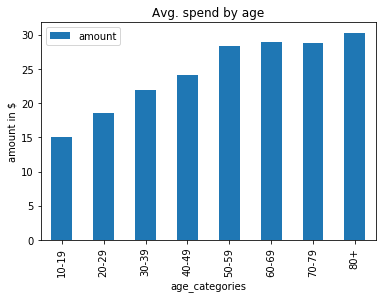

In [26]:
avg_spend_age = pd.DataFrame(offers.groupby(['age_categories'])['amount'].mean())
avg_spend_age.plot(kind='bar', title='Avg. spend by age').set_ylabel('amount in $')

Text(0, 0.5, 'conversion rate in %')

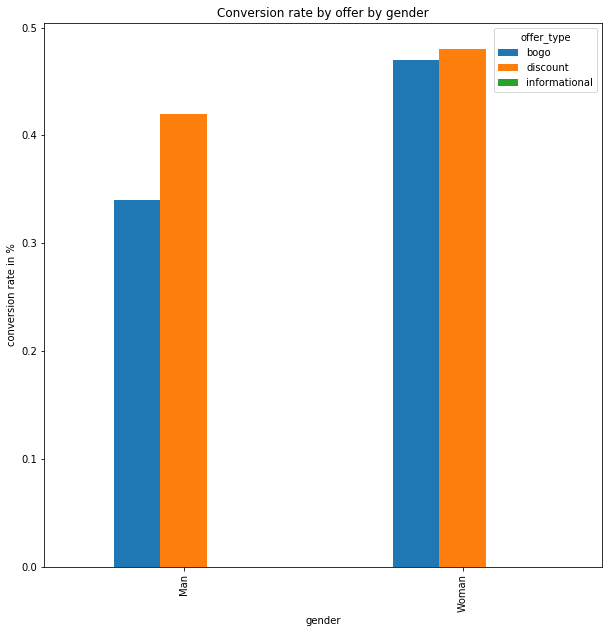

In [44]:
offer_type_cr(offers, 'gender')['conversion_rate'].rename({0: 'Man', 1: 'Woman'}).unstack().plot(kind='bar', figsize=(10, 10), title='Conversion rate by offer by gender').set_ylabel('conversion rate in %')

Text(0, 0.5, 'conversion rate in %')

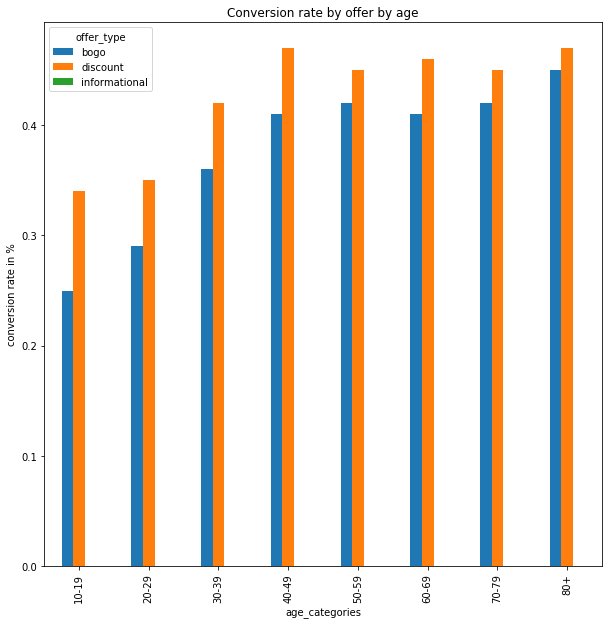

In [45]:
offer_type_cr(offers, 'age_categories')['conversion_rate'].unstack().plot(kind='bar', figsize=(10, 10), title='Conversion rate by offer by age').set_ylabel('conversion rate in %')

Text(0, 0.5, 'conversion rate in %')

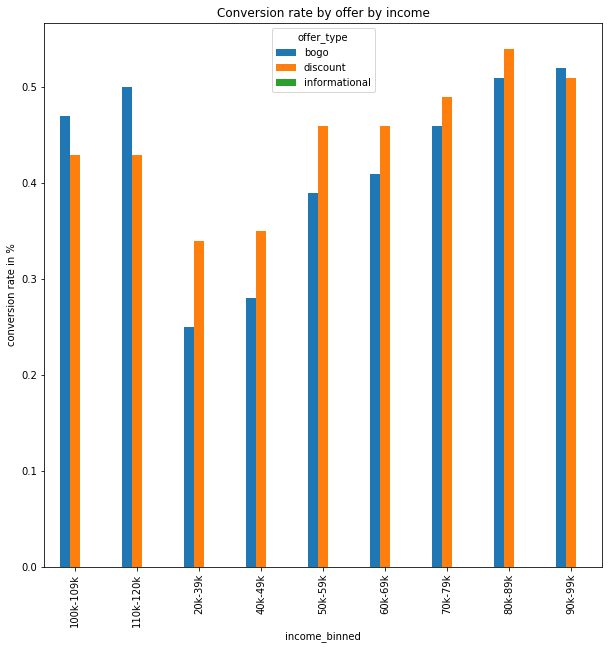

In [46]:
offer_type_cr(offers, 'income_binned')['conversion_rate'].unstack().plot(kind='bar', figsize=(10, 10), title='Conversion rate by offer by income').set_ylabel('conversion rate in %')

In [47]:
offers.columns

Index(['customer_id', 'time', 'planned_reward', 'required_spend', 'duration',
       'offer_type', 'offer_id', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web', 'offer_name', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'offer_ends',
       'completed_at', 'viewed_at', 'offer_success', 'offer_success_no_view',
       'amount', 'gender', 'age', 'became_member_on', 'income',
       'became_member_year', 'became_member_month', 'membership_duration',
       'age_categories', 'income_binned'],
      dtype='object')

Text(0, 0.5, 'conversion rate in %')

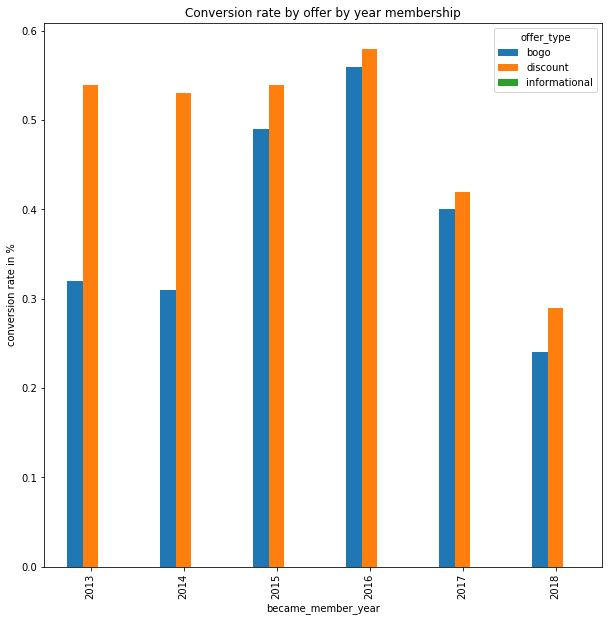

In [48]:
# probably no significance, not enough data to make a conclusion that older customers react better to discounts
offer_type_cr(offers, 'became_member_year')['conversion_rate'].unstack().plot(kind='bar', figsize=(10, 10), title='Conversion rate by offer by year membership').set_ylabel('conversion rate in %')

In [49]:
offers['became_member_year'].value_counts()

2017    24746
2018    16254
2016    13386
2015     7025
2014     2960
2013     1214
Name: became_member_year, dtype: int64

In [50]:
offers.columns

Index(['customer_id', 'time', 'planned_reward', 'required_spend', 'duration',
       'offer_type', 'offer_id', 'channel_email', 'channel_mobile',
       'channel_social', 'channel_web', 'offer_name', 'event_offer_completed',
       'event_offer_received', 'event_offer_viewed', 'offer_ends',
       'completed_at', 'viewed_at', 'offer_success', 'offer_success_no_view',
       'amount', 'gender', 'age', 'became_member_on', 'income',
       'became_member_year', 'became_member_month', 'membership_duration',
       'age_categories', 'income_binned'],
      dtype='object')

Text(0, 0.5, 'number of offers sent')

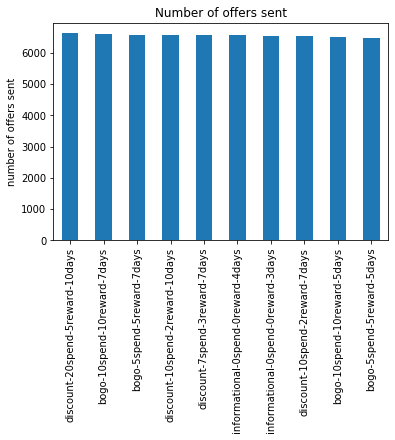

In [51]:
offers['offer_name'].value_counts().plot(kind='bar', title='Number of offers sent').set_ylabel('number of offers sent')

In [52]:
offers.groupby('gender')['offer_success'].agg(['sum', 'count'])

sum  count
gender              
0.0     11590  38129
1.0     10426  27456

In [30]:
def cr_no_view(df, metric, *cols):
    df = offers.groupby([*cols])[metric].agg(['sum', 'count'])
    idx = pd.IndexSlice
    df['conversion_rate'] = df['sum'].div(df['count'], level=1).round(2)
    return df

In [34]:
def rename_fields(df, fl=True):
    return df.rename({0: 'Man', 1: 'Woman'}).rename({'sum': 'success offers w/o view' if fl else 'success offers w/ view' , 'count': 'total offers sent'}, axis=1)

In [55]:
rename_fields(cr_no_view(offers, 'offer_success_no_view', 'gender'))\
    .plot(kind='bar', subplots=True, figsize=(15, 15), title='Conversion rate for offers w/o view by gender')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12df6c910>,
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12df48850>,
      dtype=object)

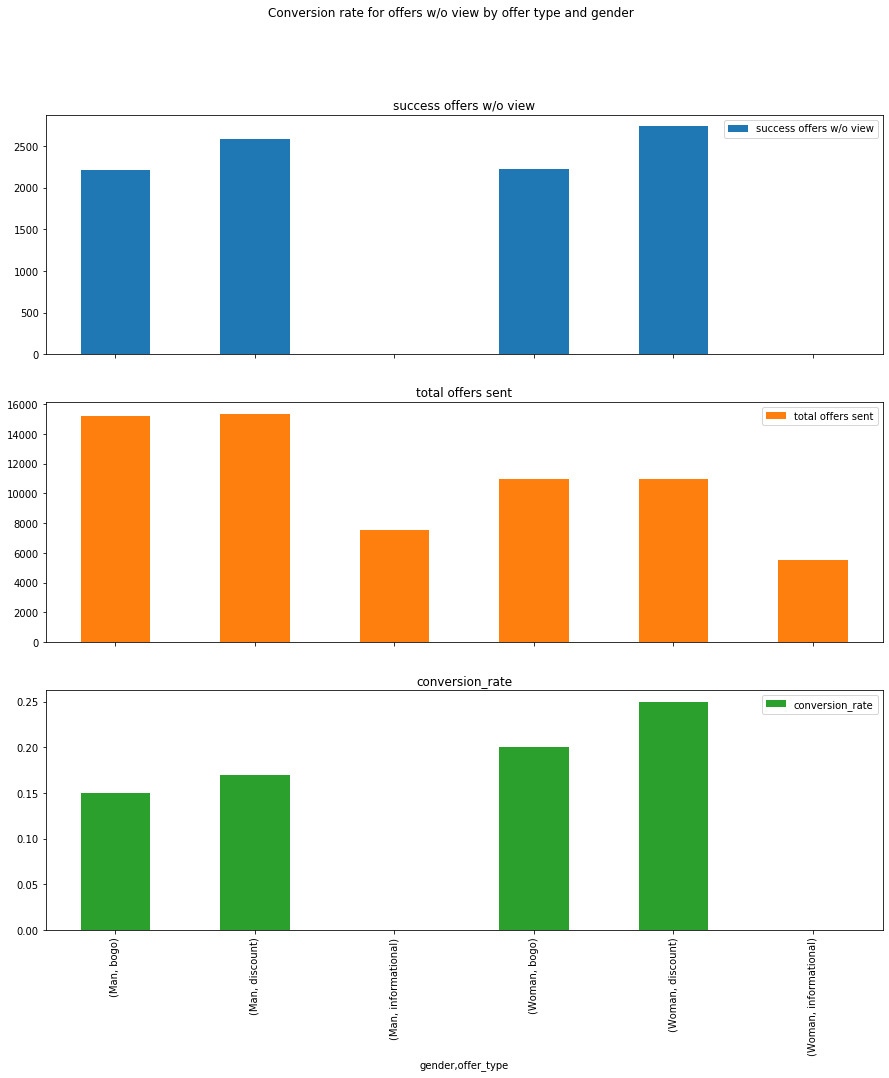

In [56]:
rename_fields(cr_no_view(offers, 'offer_success_no_view', 'gender', 'offer_type'))\
    .plot(kind='bar', subplots=True, figsize=(15, 15), title='Conversion rate for offers w/o view by offer type and gender')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x133eb6990>,
      dtype=object)

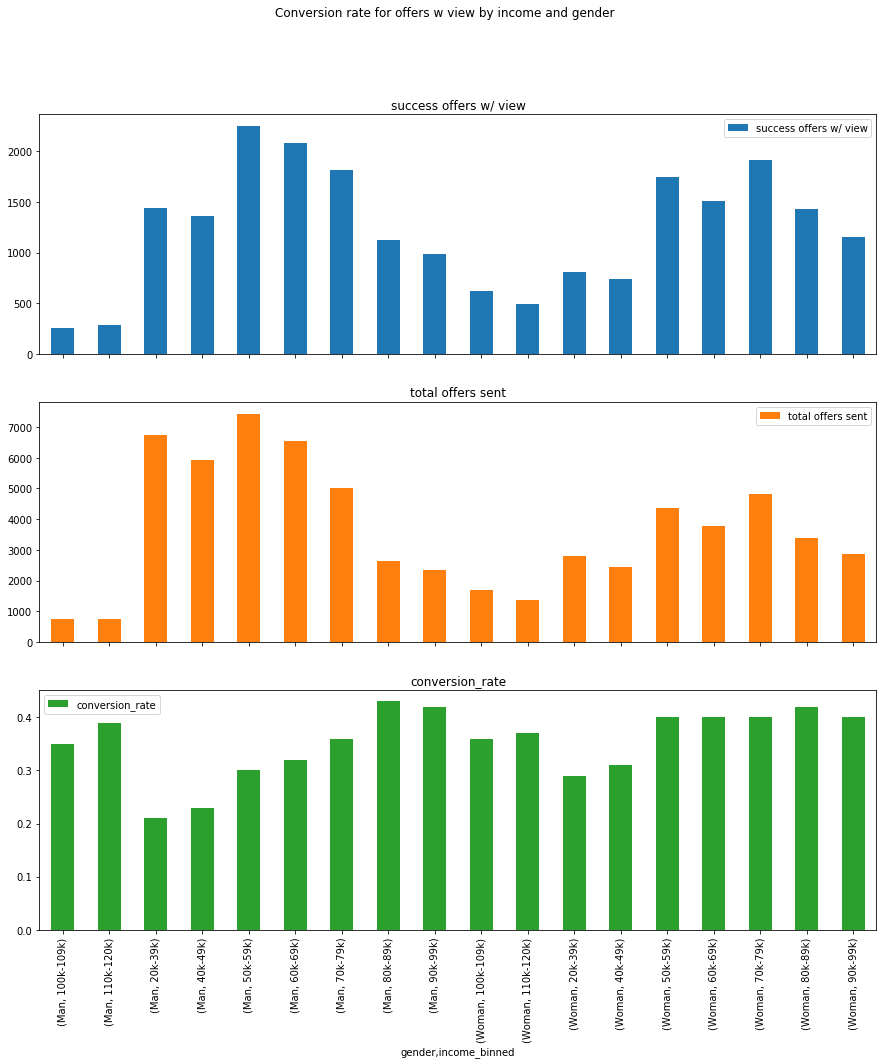

In [37]:
rename_fields(cr_no_view(offers, 'offer_success', 'gender', 'income_binned'), False)\
        .plot(kind='bar', subplots=True, figsize=(15, 15), title='Conversion rate for offers w view by income and gender')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12fb0ead0>,
      dtype=object)

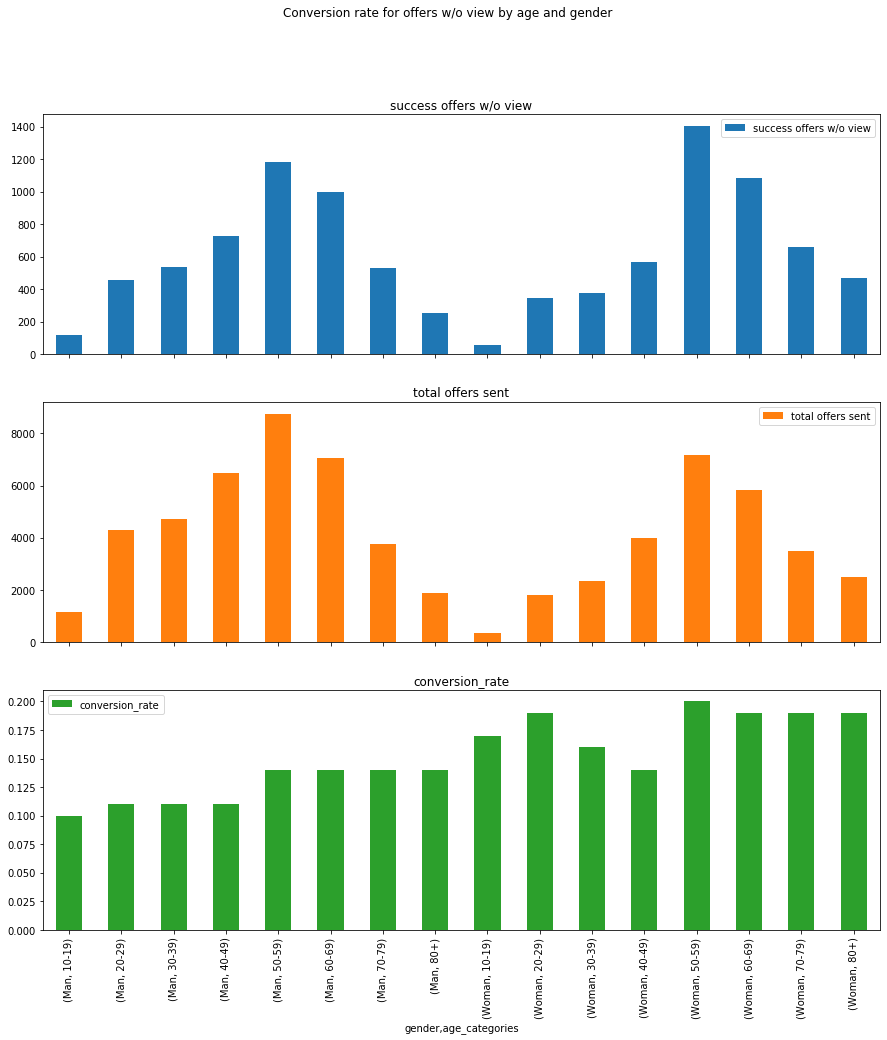

In [57]:
rename_fields(cr_no_view(offers, 'offer_success_no_view', 'gender', 'age_categories'))\
        .plot(kind='bar', subplots=True, figsize=(15, 15), title='Conversion rate for offers w/o view by age and gender')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12ed07e10>,
      dtype=object)

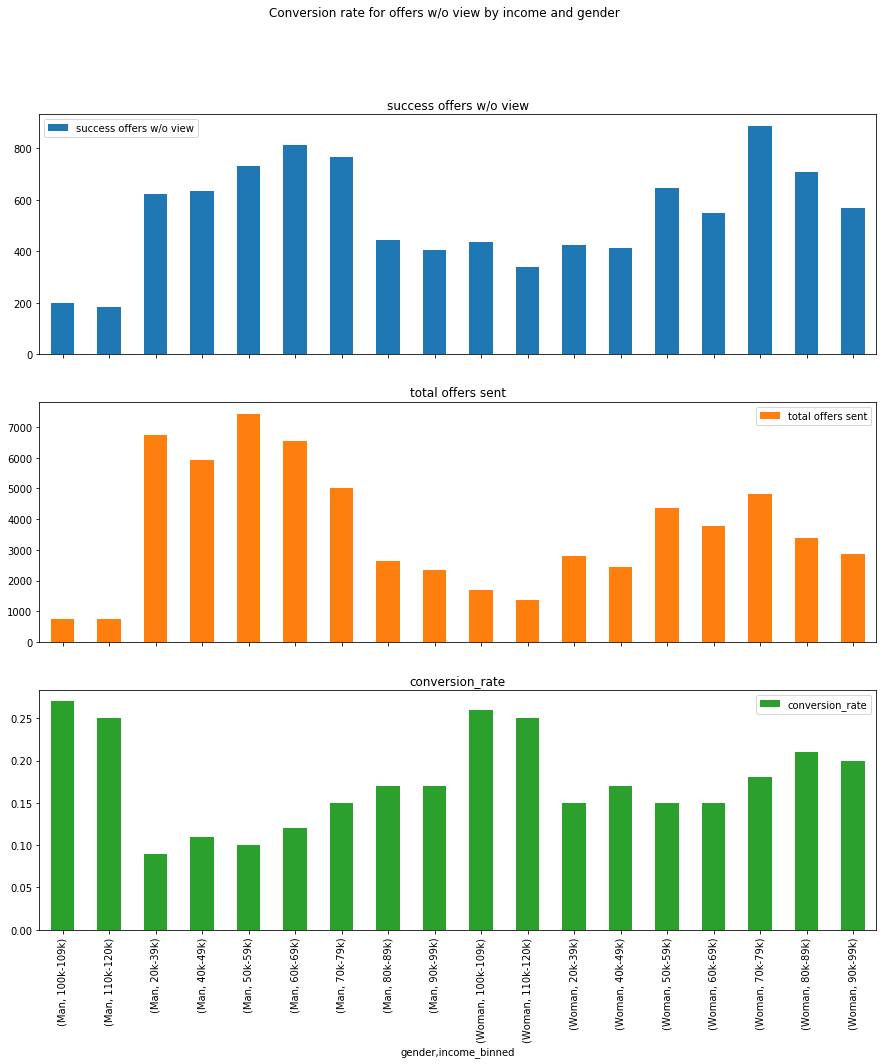

In [58]:
rename_fields(cr_no_view(offers, 'offer_success_no_view', 'gender', 'income_binned'))\
    .plot(kind='bar', subplots=True, figsize=(15, 15), title='Conversion rate for offers w/o view by income and gender')

# Feature Engineering

During this part features some of the features such as offer_names, or customer_ids will be dropped. Also other other columns that can cause problems for the algorithms will be dropped. Columns such as gender, offer_type or age_categories will be hot encoded. Features like age, income, duration and so on will be scaled for better performance.

In [83]:
offers.dtypes
offers['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

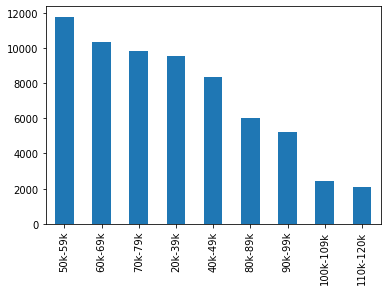

In [60]:
offers['income_binned'].value_counts().plot(kind='bar')

In [119]:
def prepare_data(df):
    df['gender'] = df['gender'].map({0: 'Man', 1: 'Woman'})
    df = df.drop(columns=['customer_id', 
                          'time', 
                          'offer_id', 
                          'offer_name', 
                          'event_offer_completed', 
                          'event_offer_received', 
                          'event_offer_viewed',
                          'offer_ends',
                          'completed_at',
                          'viewed_at',
                          'became_member_on',
                          'became_member_month',
                          'membership_duration',
                          'offer_success_no_view',
                          'income_binned',
                          'age_categories',
                          'amount' # should be dropped, since it's a posterior value
                         ], axis=1)
    df = pd.get_dummies(data=df, columns=['gender', 'offer_type'])
    return df

In [141]:
data = prepare_data(offers.copy())

In [91]:
data.columns

Index(['planned_reward', 'required_spend', 'duration', 'channel_email',
       'channel_mobile', 'channel_social', 'channel_web', 'offer_success',
       'age', 'income', 'became_member_year', 'gender_Man', 'gender_Woman',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational'],
      dtype='object')

In [142]:
# removing all informational offers, because they have no offer completions
data = data[data['offer_type_informational'] != 1]

In [143]:
X = data.drop('offer_success', axis=1)
y = data['offer_success']

Text(0, 0.5, 'amount')

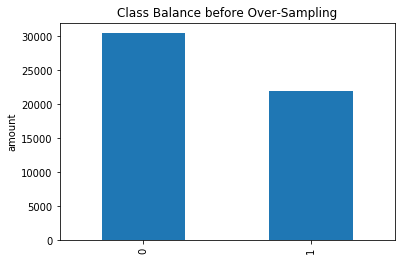

In [95]:
y.value_counts().plot(kind='bar', title='Class Balance before Over-Sampling').set_ylabel('amount')

In [144]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

Text(0, 0.5, 'amount')

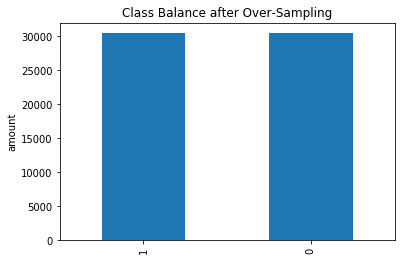

In [113]:
y_resampled.value_counts().plot(kind='bar', title='Class Balance after Over-Sampling').set_ylabel('amount')

In [68]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
X.describe()

planned_reward  required_spend      duration  channel_email  \
count    65585.000000    65585.000000  65585.000000        65585.0   
mean         4.200778        7.715499      6.507448            1.0   
std          3.399038        5.545371      2.204051            0.0   
min          0.000000        0.000000      3.000000            1.0   
25%          2.000000        5.000000      5.000000            1.0   
50%          5.000000       10.000000      7.000000            1.0   
75%          5.000000       10.000000      7.000000            1.0   
max         10.000000       20.000000     10.000000            1.0   

       channel_mobile  channel_social   channel_web        amount  \
count    65585.000000    65585.000000  65585.000000  65585.000000   
mean         0.898956        0.598765      0.799741     30.621165   
std          0.301390        0.490152      0.400197     57.855073   
min          0.000000        0.000000      0.000000      0.000000   
25%          1.000000        0.000000      1.000000      2.260000   
50%          1.000000        1.000000      1.000000     16.240000   
75%          1.000000        1.000000      1.000000     40.390000   
max          1.000000        1.000000      1.000000   1200.990000   

                age         income  became_member_year    gender_Man  \
count  65585.000000   65585.000000        65585.000000  65585.000000   
mean      54.364245   65402.470077         2016.620066      0.581368   
std       17.412684   21655.610947            1.199338      0.493339   
min       18.000000   30000.000000         2013.000000      0.000000   
25%       42.000000   49000.000000         2016.000000      0.000000   
50%       55.000000   64000.000000         2017.000000      1.000000   
75%       66.000000   80000.000000         2017.000000      1.000000   
max      101.000000  120000.000000         2018.000000      1.000000   

       gender_Woman  offer_type_bogo  offer_type_discount  \
count  65585.000000     65585.000000         65585.000000   
mean       0.418632         0.399222             0.400961   
std        0.493339         0.489742             0.490097   
min        0.000000         0.000000             0.000000   
25%        0.000000         0.000000             0.000000   
50%        0.000000         0.000000             0.000000   
75%        1.000000         1.000000             1.000000   
max        1.000000         1.000000             1.000000   

       offer_type_informational  age_categories_10-19  age_categories_20-29  \
count              65585.000000          65585.000000          65585.000000   
mean                   0.199817              0.022764              0.093329   
std                    0.399866              0.149153              0.290896   
min                    0.000000              0.000000              0.000000   
25%                    0.000000              0.000000              0.000000   
50%                    0.000000              0.000000              0.000000   
75%                    0.000000              0.000000              0.000000   
max                    1.000000              1.000000              1.000000   

       age_categories_30-39  age_categories_40-49  age_categories_50-59  \
count          65585.000000          65585.000000          65585.000000   
mean               0.108119              0.159655              0.242555   
std                0.310533              0.366289              0.428632   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%                0.000000              0.000000              0.000000   
75%                0.000000              0.000000              0.000000   
max                1.000000              1.000000              1.000000   

       age_categories_60-69  age_categories_70-79  age_categories_80+  
count          65585.000000          65585.000000        65585.000000  
mean               0.19

In [145]:
X = X_resampled
y = y_resampled

In [146]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
to_scale = ['planned_reward', 'required_spend', 'duration', 'age', 'income', 'became_member_year']
X[to_scale] = scaler.fit_transform(X[to_scale])

In [12]:
X.describe()

planned_reward  required_spend      duration  channel_email  \
count    87138.000000    87138.000000  87138.000000        87138.0   
mean         0.438733        0.399979      0.526265            1.0   
std          0.332881        0.256856      0.305567            0.0   
min          0.000000        0.000000      0.000000            1.0   
25%          0.200000        0.250000      0.285714            1.0   
50%          0.500000        0.500000      0.571429            1.0   
75%          0.500000        0.500000      0.571429            1.0   
max          1.000000        1.000000      1.000000            1.0   

       channel_mobile  channel_social   channel_web        amount  \
count    87138.000000    87138.000000  87138.000000  87138.000000   
mean         0.909397        0.639423      0.821065      0.027762   
std          0.287046        0.480171      0.383300      0.052860   
min          0.000000        0.000000      0.000000      0.000000   
25%          1.000000        0.000000      1.000000      0.000000   
50%          1.000000        1.000000      1.000000      0.015396   
75%          1.000000        1.000000      1.000000      0.038947   
max          1.000000        1.000000      1.000000      1.000000   

                age        income  ...  offer_type_discount  \
count  87138.000000  87138.000000  ...         87138.000000   
mean       0.442104      0.403720  ...             0.432326   
std        0.207864      0.239731  ...             0.495402   
min        0.000000      0.000000  ...             0.000000   
25%        0.301205      0.222222  ...             0.000000   
50%        0.457831      0.388889  ...             0.000000   
75%        0.590361      0.566667  ...             1.000000   
max        1.000000      1.000000  ...             1.000000   

       offer_type_informational  age_categories_10-19  age_categories_20-29  \
count              87138.000000           87138.00000          87138.000000   
mean                   0.150394               0.02099              0.088193   
std                    0.357459               0.14335              0.283578   
min                    0.000000               0.00000              0.000000   
25%                    0.000000               0.00000              0.000000   
50%                    0.000000               0.00000              0.000000   
75%                    0.000000               0.00000              0.000000   
max                    1.000000               1.00000              1.000000   

       age_categories_30-39  age_categories_40-49  age_categories_50-59  \
count          87138.000000          87138.000000          87138.000000   
mean               0.106372              0.161043              0.244979   
std                0.308314              0.367573              0.430077   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%                0.000000              0.000000              0.000000   
75%                0.000000              0.000000              0.000000   
max                1.000000              1.000000              1.000000   

       age_categories_60-69  age_categories_70-79  age_categories_80+  
count          87138.000000          87138.000000        87138.000000  
mean               0.199419              0.111157            0.067846  
std                0.399566              0.314328            0.251484  
min                0.000000              0.000000            0.000000  
25%                0.000000              0.000000            0.000000  
50%                0.000000              0.000000            0.000000  
75%                0.000000              0.000000            0.000000  
max                1.000000              1.000000            1.000000  

[8 rows x 24 columns]

# Algorithm Selection & Model Training

As a baseline algorithm a Naive classifier will be used. To find the optimal algorithm, a brute-force approach will be used. To see which algorithm performs best. Also the plan is to use ensembles, they seem to be reasonable for such type of a problem.

In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, shuffle=True)

In [100]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

def evaluate(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print(f'Accuracy: {round(accuracy_score(y_test, y_pred) * 100, 2)}%')
    print(f'F1 Score: {round(f1_score(y_test, y_pred) * 100, 2)}%')
    print(f'Recall Score: {round(precision_score(y_test, y_pred) * 100, 2)}%')
    print(f'Precision Score: {round(recall_score(y_test, y_pred) * 100, 2)}%')

def plot_cfm(clf, X_test, y_test):
    plot_confusion_matrix(clf, X_test, y_test, normalize='true')

In [101]:
class Naive_CLF:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        pass
    
    def predict(self, x):
        x = x.copy()
        x = x.to_numpy()[:, 0]
        x[:] = 1
        return x

In [102]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer

clf = Naive_CLF()

evaluate(clf, X_test, y_test)


Accuracy: 49.84%
F1 Score: 66.52%
Recall Score: 49.84%
Precision Score: 100.0%


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LR: 0.656867 (0.008687)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LDA: 0.656744 (0.008456)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.673669 (0.006510)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CART: 0.690452 (0.005717)
NB: 0.631139 (0.008212)


/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


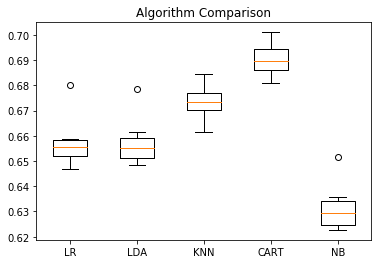

In [111]:
# https://machinelearningmastery.com/machine-learning-in-python-step-by-step/
# compare algorithms
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC



# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC(gamma='auto')))

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [112]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=7, n_estimators=600, learning_rate=0.02, objective='binary:logistic', random_state=7)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=7, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [114]:
plot_cfm(xgb, X_test, y_test)
evaluate(xgb, X_test, y_test)

Accuracy: 69.89%
F1 Score: 70.13%
Recall Score: 69.35%
Precision Score: 70.94%


In [115]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

ada = AdaBoostClassifier(RandomForestClassifier(max_depth=10, n_estimators=250), n_estimators=10, random_state=7)
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

Accuracy: 70.01%
F1 Score: 70.48%
Recall Score: 69.18%
Precision Score: 71.83%


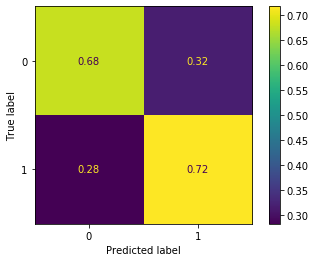

In [116]:
plot_cfm(ada, X_test, y_test)
evaluate(ada, X_test, y_test)

In [117]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Accuracy: 68.33%
F1 Score: 68.65%
Recall Score: 67.75%
Precision Score: 69.57%


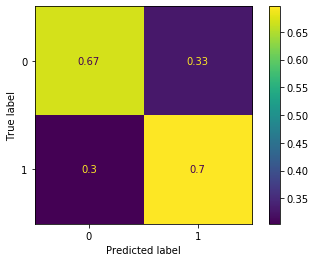

In [118]:
plot_cfm(gbc, X_test, y_test)
evaluate(gbc, X_test, y_test)

In [148]:
from sklearn.ensemble import RandomForestClassifier

rdf = RandomForestClassifier()
rdf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [149]:
plot_cfm(rdf, X_test, y_test)
evaluate(rdf, X_test, y_test)

Accuracy: 71.25%
F1 Score: 72.11%
Recall Score: 69.81%
Precision Score: 74.58%


In [105]:
# https://github.com/udacity/machine-learning/blob/master/projects/finding_donors/visuals.py

def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Create the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(7), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.show()

In [150]:
feature_plot(rdf.feature_importances_, X_train, y_train)

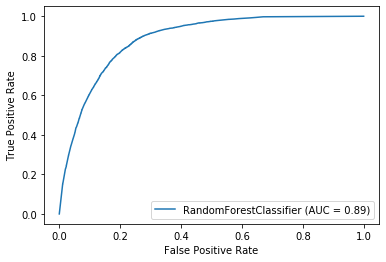

In [67]:
from sklearn.metrics import plot_roc_curve

rdf_disp = plot_roc_curve(rdf, X_test, y_test)
plt.show()

In [154]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [155]:
plot_cfm(svc, X_test, y_test)
evaluate(svc, X_test, y_test)

Accuracy: 67.16%
F1 Score: 66.76%
Recall Score: 67.35%
Precision Score: 66.18%


# Stacking

The idea behind stacking is to use first level models to make predictions and then use these predictions as features to the second level models.

In [2]:
#!pip install vecstack

  Using cached https://files.pythonhosted.org/packages/d0/a1/b9a1e9e9e5a12078da1ab9788c7885e4c745358f7e57d5f94d9db6a4e898/vecstack-0.4.0.tar.gz
  Stored in directory: /Users/tarasowski/Library/Caches/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


In [160]:
from vecstack import stacking
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


models = [DecisionTreeClassifier(), 
          RandomForestClassifier(random_state=7),
          XGBClassifier(objective='binary:logistic', random_state=7),
          AdaBoostClassifier(random_state=7),
          GradientBoostingClassifier(random_state=7)
    
]

S_train, S_test = stacking(models,
                          X_train, y_train, X_test, regression=False,
                          mode='oof_pred_bag',
                          needs_proba=False,
                          save_dir=None,
                          metric=accuracy_score,
                          n_folds=4,
                          stratified=True,
                          shuffle=True,
                          random_state=7,
                          verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.68332513]
    fold  1:  [0.68160184]
    fold  2:  [0.67558474]
    fold  3:  [0.68239639]
    ----
    MEAN:     [0.68072702] + [0.00303090]
    FULL:     [0.68072709]

model  1:     [RandomForestClassifier]
    fold  0:  [0.70113245]
    fold  1:  [0.70613819]
    fold  2:  [0.70299549]
    fold  3:  [0.70898646]
    ----
    MEAN:     [0.70481315] + [0.00300099]
    FULL:     [0.70481310]

model  2:     [XGBClassifier]
    fold  0:  [0.69423929]
    fold  1:  [0.69981946]
    fold  2:  [0.69093147]
    fold  3:  [0.69249077]
    ----
    MEAN:     [0.69437025] + [0.00335666]
    FULL:     [0.69437036]

model  3:     [AdaBoostClassifier]
    fold  0:  [0.67881175]
    fold  1:  [0.68069916]
    fold  2:  [0.67320476]
    fold  3:  [0.67706196]
    ----
    MEAN:     [0.67744441] + [0.00276514]
    FULL:

In [161]:
from sklearn.metrics import f1_score, precision_score, recall_score

model = RandomForestClassifier(random_state=7)
model = model.fit(S_train, y_train)

plot_cfm(model, S_test, y_test)
evaluate(model, S_test, y_test)

Accuracy: 73.05%
F1 Score: 74.55%
Recall Score: 70.41%
Precision Score: 79.22%


# Model Tuning: Grid Search

The plan is to train the model locally and to use grid search to find the optimal hyper-parameters. The optimization with grid search will be the last step once the best algorithm was found.

In [166]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

param_grid = { 
     'n_estimators': [50, 100, 150],
     'max_depth': [5, 8, 15, 25],
     'min_samples_split': [2, 5, 10, 15],
     'min_samples_leaf': [1, 2, 5, 10] 
}

scorer = make_scorer(recall_score)

grid_obj = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=10, scoring=scorer, n_jobs=-1)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
best_clf

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=15,
              min_child_weight=1, min_samples_leaf=1, min_samples_split=2,
              missing=nan, monotone_constraints=None, n_estimators=50, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [167]:
evaluate(best_clf, X_test, y_test)
plot_cfm(best_clf, X_test, y_test)

Accuracy: 72.21%
F1 Score: 72.99%
Recall Score: 70.79%
Precision Score: 75.33%
